In [1]:
# !pip install -U torch catalyst tensorboard

# Variational AutoEncoders

Hi! Today we are going to learn about variationals autoencoders. We'll code them to encode handwritten numbers and restore them from the compact vector representation.

In [2]:
from catalyst.utils import set_global_seed, get_device

In [3]:
set_global_seed(42)
device = get_device()

We'll work with `MNIST` dataset. Download it, show examples of the writting and prepare the dataset to be loaded into models.

In [4]:
from catalyst.contrib.datasets import mnist


train = mnist.MNIST(".", train=True, download=True)
valid = mnist.MNIST(".", train=False, download=True)

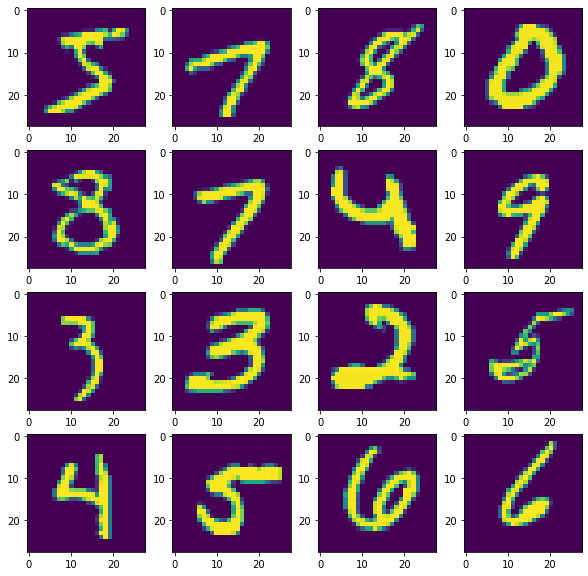

In [5]:
import matplotlib.pyplot as plt


_, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    axs[i // 4][i % 4].imshow(train[100 * i + i][0])

In [6]:
import torch
import torch.nn as nn

In [7]:
from catalyst.dl.utils import get_loader


batch_size = 256
num_workers = 4

def transform(x):
    image = torch.FloatTensor(x["image"])
    image = # Use torch.where, to replace 256 values to ones or zeros
    return {'image': image, "targets": x["targets"]}


train_data_loader = get_loader(
    train,
    open_fn=lambda x : {'image': x[0].reshape(1, 28, 28), 'targets': x[1]},
    dict_transform=transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    sampler=None,
    drop_last=True,
)

valid_data_loader = get_loader(
    valid,
    open_fn=lambda x : {'image': x[0].reshape(1, 28, 28), 'targets': x[1]},
    dict_transform=transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    sampler=None,
    drop_last=False,
)

A variational autoencoder consists of two parts: encoder and decoder. The encoder shrinks objects into some vector. The decoder generates an proximate an "image" of object. In our case, objects are images. We will use CNNs for encoding images and UpScale Convolution operations for decoding.

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_size=2):
        super().__init__()

        # Create encoder model!
        self.feature_extractor = ...
        self.latent_space = ...
        
        self.latent_size = latent_size
        
    def forward(self, images):
        features = self.feature_extractor(images)
        latent = self.latent_space(features)
        return latent[:, :self.latent_size], latent[:, self.latent_size:]

In [9]:
from catalyst.contrib.nn.modules import Lambda


class Decoder(nn.Module):
    def __init__(self, image_size=(28, 28), latent_size=2):
        super().__init__()
        
        self.image_size = image_size
        self.latent_size = latent_size

        # Create Decoder model!
        self.map_generator = ...
        self.deconv = ...
        self.output = ...
            
    def forward(self, points):
        feature_map = self.map_generator(points)
        feature_map = self.deconv(feature_map)
        return self.output(feature_map)
            
    def make_up_layer_(self, in_channels, out_channels):
        return ...

Joint the encoder and decoder to create VAE! We have discussed in the lecture about it, and we knew how to train VAE. We need sample points in latent space, pass them forward through the decoder and compare a decoder result with original object. Also we should sample points from some normal distribution, which parameters approach to $(0, I)$.

In [10]:
LOG_SCALE_MAX = 2
LOG_SCALE_MIN = -10

def normal_sample(loc, log_scale):
    scale = torch.exp(0.5 * log_scale)
    return loc + scale * torch.randn_like(scale)


class VAE(nn.Module):
    def __init__(self, image_size=(28, 28), latent_size=2):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(image_size, latent_size)
        
    def forward(self, images):
        loc, log_scale = ... # get loc and scale for sampling
        log_scale = torch.clamp(log_scale, LOG_SCALE_MIN, LOG_SCALE_MAX)

        z_ = normal_sample(loc, log_scale) if self.training else loc
        x_ = ... # recreate object from z_

        return {
            "decoder_result": x_,
            "loc": loc,
            "log_scale": log_scale
        }

In [11]:
class KLVAELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, loc, log_scale):
        return (-0.5 * torch.sum(1 + log_scale - loc.pow(2) - log_scale.exp(), dim=1)).mean()

We need to modify `BinaryCrossEntropyLoss` function, because it doesn't work properly with images.

In [12]:
class ImageCELoss(nn.BCEWithLogitsLoss):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target):
        input = ... # reshape input to (batch_size * ...)
        target = ... # reshape target to (batch_size * ...)
        return super().forward(input, target)

To monitor decoded images, we have to write a new callback function. It will log image into the tensorboard.

In [13]:
from catalyst.core import Callback, CallbackOrder


class LogFigureCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.External)

    def on_epoch_end(self, runner):
        if runner.is_valid_loader:
            tb_callback = runner.callbacks["_tensorboard"]
            logger = tb_callback.loggers[runner.loader_name]
            decoder_result = runner.output["decoder_result"]
            logger.add_images(
                "image/epoch", 
                # create image from decoder result
                global_step=runner.epoch
            )

Create model, criterion, optimizer. Train model!

In [14]:
from catalyst.contrib.nn.optimizers import RAdam


model = VAE()
criterion = {
    "ae": ImageCELoss(),
    "kl": KLVAELoss()
}
optimizer = RAdam(model.parameters(), lr=1e-2)

In [15]:
from catalyst import dl


callbacks = [
    dl.CriterionCallback(
        input_key="features", output_key="decoder_result", prefix="loss_ae", criterion_key="ae",
    ),
    dl.CriterionCallback(
        input_key=None, output_key=["loc", "log_scale"], prefix="loss_kl", criterion_key="kl"
    ),
    dl.MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_ae": 1.0, "loss_kl": 0.01},
    ),
    LogFigureCallback(),
]

In [16]:
class VAERunner(dl.SupervisedRunner):
    def predict_batch(self, batch):
        prediction = {"features": batch["image"], "targets": batch["targets"]}
        prediction.update(self.model(batch["image"]))
        return prediction
    
    def _handle_batch(self, batch):
        self.input = {"features": batch["image"], "targets": batch["targets"]}
        self.output = self.model(batch["image"])


runner = VAERunner()

In [17]:
from datetime import datetime
from pathlib import Path


logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")

# %reload_ext tensorboard
# %tensorboard --logdir logs

In [18]:
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders={"train": train_data_loader, "valid": valid_data_loader},
    callbacks=callbacks,
    num_epochs=1,
    verbose=True,
    logdir=logdir,
    main_metric="loss_ae",
    minimize_metric=True,
)

1/1 * Epoch (train):   1% 3/234 [00:20<55:39, 14.46s/it, loss=0.728, loss_ae=0.728, loss_kl=0.007]  

/home/adchumachenko/.local/lib/python3.6/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



1/1 * Epoch (train): 100% 234/234 [00:31<00:00,  7.37it/s, loss=0.253, loss_ae=0.243, loss_kl=0.936]
1/1 * Epoch (valid): 100% 40/40 [00:01<00:00, 22.40it/s, loss=0.258, loss_ae=0.247, loss_kl=1.095]
[2020-10-16 12:37:03,392] 
1/1 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/1 * Epoch 1 (train): loss=0.3700 | loss_ae=0.3675 | loss_kl=0.2464
1/1 * Epoch 1 (valid): loss=0.2533 | loss_ae=0.2433 | loss_kl=1.0007
Top best models:
logs/20201016-123626/checkpoints/train.1.pth	0.2433


One of the main feature of VAE it's a generating new objects. We can do this by mixing latent representation of objects.

In [19]:
test_data = next(iter(valid_data_loader))
test_data["targets"]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1,
        7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5,
        1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1,
        0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1,
        5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7])

In [20]:
model.eval()
locs, _ = ... # get model prediction on test_data

In [21]:
import numpy as np


def plot_transition(i, j):
    _, ax = plt.subplots(1, 11, figsize=(15, 5))
    
    line = np.linspace(0, 1, 11)
    for k in range(0, 11):
        point = line[k] * locs[j] + (1 - line[k]) * locs[i]
        decoded = ... # create image from point
        ax[k].imshow(...) # plot decoded!

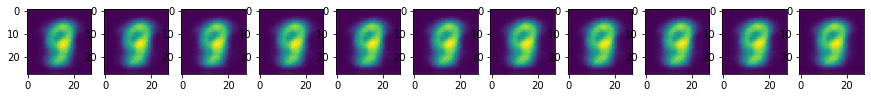

In [22]:
plot_transition(0, -3)

We can enhance generated images by many ways. And we choose to add classification task. The model will classify object based on the corresponding latent representation.

In [23]:
class VAEClassify(nn.Module):
    def __init__(self, num_classes=10, image_size=(28, 28), latent_size=10):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(image_size, latent_size)
        self.clf = ...  # Add classifier
        
    def forward(self, images):
        loc, log_scale = self.encoder(images)
        log_scale = torch.clamp(log_scale, LOG_SCALE_MIN, LOG_SCALE_MAX)

        z_ = normal_sample(loc, log_scale) if self.training else loc
        x_ = self.decoder(z_)

        logits = self.clf(z_)
        return {
            "logits": logits, 
            "decoder_result": x_,
            "loc": loc,
            "log_scale": log_scale
        }

In [24]:
from catalyst.contrib.nn.optimizers import RAdam


model = VAEClassify()
criterion = {
    "ce": nn.CrossEntropyLoss(),
    "ae": ImageCELoss(),
    "kl": KLVAELoss()
}
optimizer = RAdam(model.parameters(), lr=1e-2)

In [25]:
callbacks = [
    dl.CriterionCallback(
        input_key="features", output_key="decoder_result", prefix="loss_ae", criterion_key="ae",
    ),
    dl.CriterionCallback(
        input_key=None, output_key=["loc", "log_scale"], prefix="loss_kl", criterion_key="kl"
    ),
    dl.CriterionCallback(
        input_key="targets", output_key="logits", prefix="loss_ce", criterion_key="ce",
    ),
    dl.MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_ae": 1.0, "loss_kl": 0.01, "loss_ce": 1.0},
    ),
    dl.AccuracyCallback(),
    LogFigureCallback(),
]

In [26]:
runner = VAERunner()

runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders={"train": train_data_loader, "valid": valid_data_loader},
    callbacks=callbacks,
    num_epochs=1,
    verbose=True,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    main_metric="loss_ae",
    minimize_metric=True,
)

1/1 * Epoch (train): 100% 234/234 [00:12<00:00, 18.68it/s, accuracy01=0.930, loss=0.665, loss_ae=0.204, loss_ce=0.258, loss_kl=20.277]
1/1 * Epoch (valid): 100% 40/40 [00:02<00:00, 19.97it/s, accuracy01=1.000, loss=0.532, loss_ae=0.191, loss_ce=0.109, loss_kl=23.192]
[2020-10-16 12:37:19,905] 
1/1 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6112 | loss=1.6751 | loss_ae=0.3427 | loss_ce=1.1760 | loss_kl=15.6428
1/1 * Epoch 1 (valid): accuracy01=0.9469 | loss=0.6529 | loss_ae=0.1980 | loss_ce=0.2442 | loss_kl=21.0630
Top best models:
logs/20201016-123705/checkpoints/train.1.pth	0.1980


Let's compare results with the usual VAE.

In [27]:
model.eval()
locs, _ = model.encoder(test_data["image"].to(device))

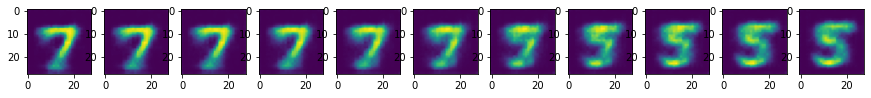

In [28]:
plot_transition(0, -3)

Let's check how our model restore noised objects. The model aren't trained to restore, but it can do this very well.

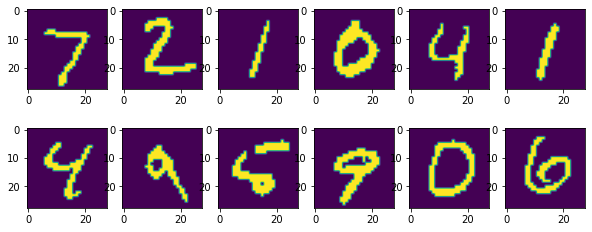

In [29]:
_, ax = plt.subplots(2, 6, figsize=(10, 4))
    
for k in range(0, 12):
    image = test_data["image"][k]
    ax[k // 6][k % 6].imshow(image.squeeze().cpu().detach().numpy())

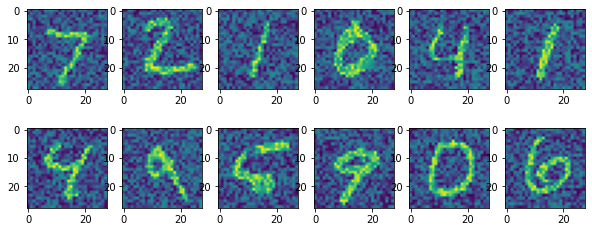

In [30]:
_, ax = plt.subplots(2, 6, figsize=(10, 4))
    
for k in range(0, 12):
    image = test_data["image"][k]
    noise = ... # let's make some noise
    ax[k // 6][k % 6].imshow((image + noise).squeeze().cpu().detach().numpy())

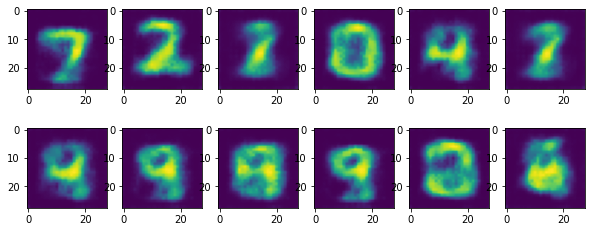

In [31]:
_, ax = plt.subplots(2, 6, figsize=(10, 4))
    
for k in range(0, 12):
    image = test_data["image"][k]
    noise = ... # let's make some noise
    point, _ = ... # get noised objects vector representation from latent space
    decoded = ... # decode points
    ax[k // 6][k % 6].imshow(...) # plot decoded

In the end, let's look at the latent space. We choose 2D plain space, so it's easy to plot the points.

In [32]:
predictions = {"loc": [], "target": []}

for pred in runner.predict_loader(loader=valid_data_loader):
    ... # Put predicted loc and targets from pred into predictions

In [33]:
predictions["x"] = [o[0] for o in predictions["loc"]]
predictions["y"] = [o[1] for o in predictions["loc"]]

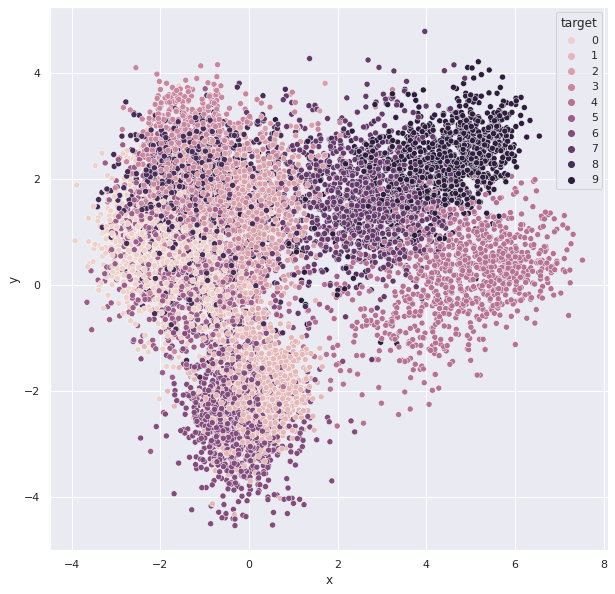

In [34]:
import seaborn as sns

sns.set()

# Use sns.scatterplot to show points !